# 1、模型推理

In [1]:
from infer_vis_utils import *

In [2]:
# jupter 缘故，args需要在py中设置默认值
img_path = "/home/kerry/project/digital-ai-eye-model/trian/Paddle3D/datasets/KITTI/training/image_2/000006.png"
args = parse_args(img_path)
args

Namespace(collect_dynamic_shape_info=False, dynamic_shape_file='dynamic_shape_info.txt', image='/home/kerry/project/digital-ai-eye-model/trian/Paddle3D/datasets/KITTI/training/image_2/000006.png', model_file='/home/kerry/project/digital-ai-eye-model/trian/Paddle3D/exported_model/inference.pdmodel', params_file='/home/kerry/project/digital-ai-eye-model/trian/Paddle3D/exported_model/inference.pdiparams', use_gpu=False, use_trt=False)

In [3]:
K = load_calibration_info(convert_to_calib_path(args.image))[2][:3, :3]
K

array([[718.3351,   0.    , 600.3891],
       [  0.    , 718.3351, 181.5122],
       [  0.    ,   0.    ,   1.    ]], dtype=float32)

In [4]:
pred = init_predictor(args)

I0923 18:00:35.950598 17122 analysis_predictor.cc:964] MKLDNN is enabled
--- Running analysis [ir_graph_build_pass]
--- Running analysis [ir_graph_clean_pass]
--- Running analysis [ir_analysis_pass]
--- Running IR pass [mkldnn_placement_pass]
--- Running IR pass [simplify_with_basic_ops_pass]
--- Running IR pass [layer_norm_fuse_pass]
---    Fused 0 subgraphs into layer_norm op.
--- Running IR pass [attention_lstm_fuse_pass]
--- Running IR pass [seqconv_eltadd_relu_fuse_pass]
--- Running IR pass [seqpool_cvm_concat_fuse_pass]
--- Running IR pass [mul_lstm_fuse_pass]
--- Running IR pass [fc_gru_fuse_pass]
---    fused 0 pairs of fc gru patterns
--- Running IR pass [mul_gru_fuse_pass]
--- Running IR pass [seq_concat_fc_fuse_pass]
--- Running IR pass [gpu_cpu_squeeze2_matmul_fuse_pass]
--- Running IR pass [gpu_cpu_flatten2_matmul_fuse_pass]
--- Running IR pass [matmul_v2_scale_fuse_pass]
--- Running IR pass [gpu_cpu_map_matmul_v2_to_mul_pass]
--- Running IR pass [gpu_cpu_map_matmul_v2_to_

In [5]:
img, ori_img_size, output_size = get_img(args.image)
ratio = get_ratio(ori_img_size, output_size)

In [6]:
results = run(pred, [img, np.array([K]), ratio])
total_pred = results[0]

I0923 18:00:36.443948 17122 device_context.cc:737] oneDNN v2.5.4


# 2、3d坐标和航向角可视化

1 基于原点，计算3D box的8个顶点加上中心点偏移
2 根据偏航角调整8个顶点
3 根据相机内参，计算投影到图像上的坐标
4 使用opencv自行将坐标绘制出来，连线

In [7]:
kitti_records = total_pred_by_conf_to_kitti_records(total_pred, conf=0.5)
bboxes_2d, bboxes_3d, labels = camera_record_to_object(kitti_records)

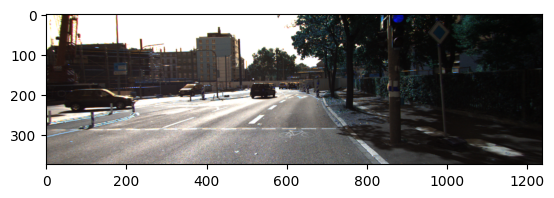

In [8]:
img_origin = cv2.imread(args.image)
plt.imshow(img_origin)

In [9]:
imgpts_list = []
for i, (box3d, label) in enumerate(zip(bboxes_3d, labels)):

    locs = np.array(box3d[0:3])
    rot_y = np.array(box3d[6])

    height, width, length = box3d[3:6]
    point, box2d, box3d = encode_label(
        K, rot_y, np.array([length, height, width]), locs
    )

    if np.all(box2d == 0):
        continue
    # 默认外参矩阵不变化
    rvec = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    tvec = np.array([[0.0], [0.0], [0.0]])

    imgpts, jac = cv2.projectPoints(box3d.T, rvec, tvec, K, 0)
    imgpts_list.append(imgpts)

In [10]:
def draw_smoke_3d(img: np.array, imgpts_list: List) -> np.array:

    connect_line_id = [
        [1, 0],
        [2, 7],
        [3, 6],
        [4, 5],
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 1],
        [0, 7],
        [7, 6],
        [6, 5],
        [5, 0],
    ]

    img_draw = img.copy()
    for imgpts in imgpts_list:
        for p_idx, p in enumerate(imgpts):
            p_x, p_y = int(p[0][0]), int(p[0][1])
            cv2.circle(img_draw, (p_x, p_y), 1, (0, 255, 0), -1)
            # cv2.putText(
            #     img_draw,
            #     str(p_idx),
            #     (p_x, p_y),
            #     cv2.FONT_HERSHEY_SIMPLEX,
            #     0.5,
            #     (0, 0, 255),
            #     1,
            # )
        for i, line_id in enumerate(connect_line_id):

            p1 = (int(imgpts[line_id[0]][0][0]), int(imgpts[line_id[0]][0][1]))
            p2 = (int(imgpts[line_id[1]][0][0]), int(imgpts[line_id[1]][0][1]))

            if i <= 3:  # 车身
                color = (255, 0, 0)
            elif i <= 7:  # 车头
                color = (0, 0, 255)
            else:  # 车尾巴
                color = (255, 255, 0)

            cv2.line(img_draw, p1, p2, color, 1)

    return img_draw

True

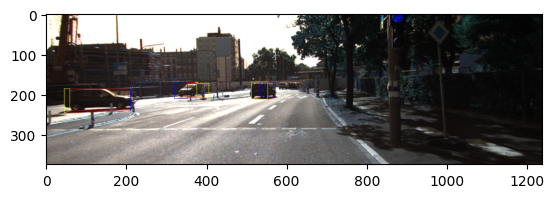

In [11]:
img_draw = draw_smoke_3d(img_origin, imgpts_list)
plt.imshow(img_draw)
cv2.imwrite("output.bmp", img_draw)